In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report 

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt
import glob
import random

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
import keras
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model
import imgaug.augmenters as iaa

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data_path = '/kaggle/input/lung-cancer-histopathological-after-prerpocessing/data_after_prerocessing'

In [3]:
classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

print("Dataset Classes:")
for cls in classes:
    print(cls)

Dataset Classes:
lung_aca
lung_n
lung_scc


In [4]:
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrame for the dataset
df = create_dataframe(data_path)

In [5]:
# Step 1: Split into 70% training and 30% dummy, stratifying by labels
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42, stratify=df['Labels'])

# Step 2: Split dummy_df into 20% testing and 10% validation, stratifying by labels
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42, stratify=dummy_df['Labels'])

In [6]:
train_datagen = ImageDataGenerator()
# Validation and test data generators remain the same
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [8]:
# Load the VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for our specific classification task
x = base_model.output
x = Flatten()(x)                 
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)     
output = Dense(3, activation='softmax')(x) 

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Train the model and store training details in history
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    batch_size=32
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732888390.967305      65 service.cc:145] XLA service 0x7d576000d530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732888390.967366      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/329 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.3594 - loss: 14.8444   

I0000 00:00:1732888401.107223      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 ━━━━━━━━━━━━━━━━━━━━ 91s 238ms/step - accuracy: 0.7910 - loss: 3.2635 - val_accuracy: 0.9020 - val_loss: 0.2787
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.9142 - loss: 0.2480 - val_accuracy: 0.9160 - val_loss: 0.2691
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.9426 - loss: 0.1636 - val_accuracy: 0.9320 - val_loss: 0.2274
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - accuracy: 0.9567 - loss: 0.1111 - val_accuracy: 0.9413 - val_loss: 0.1989
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - accuracy: 0.9694 - loss: 0.0832 - val_accuracy: 0.9487 - val_loss: 0.1685
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - accuracy: 0.9768 - loss: 0.0634 - val_accuracy: 0.9500 - val_loss: 0.1638
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.9794 - loss: 0.0525 - val_accuracy: 0.9460 - val_loss: 0.2559
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9794 - loss: 0.0639 - val_acc

In [11]:
# Evaluate the model on the training data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Training Loss: {train_scores[0]:.4f}")
print(f"Training Accuracy: {train_scores[1]:.4f}")

# Evaluate the model on the test data
test_scores = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")

Training Loss: 0.0001
Training Accuracy: 1.0000
Test Loss: 0.2280
Test Accuracy: 0.9640


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step


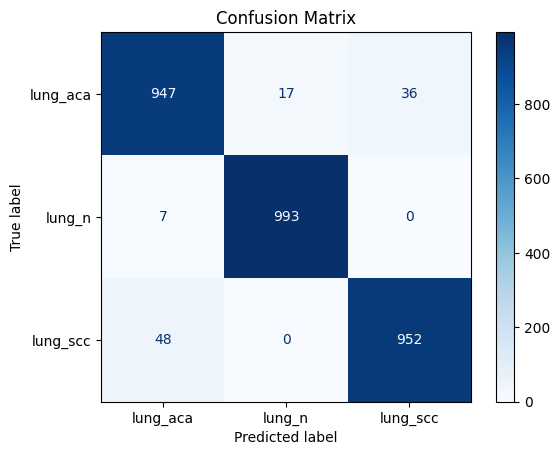

In [12]:
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
from sklearn.metrics import classification_report  
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step
              precision    recall  f1-score   support

    lung_aca       0.95      0.95      0.95      1000
      lung_n       0.98      0.99      0.99      1000
    lung_scc       0.96      0.95      0.96      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



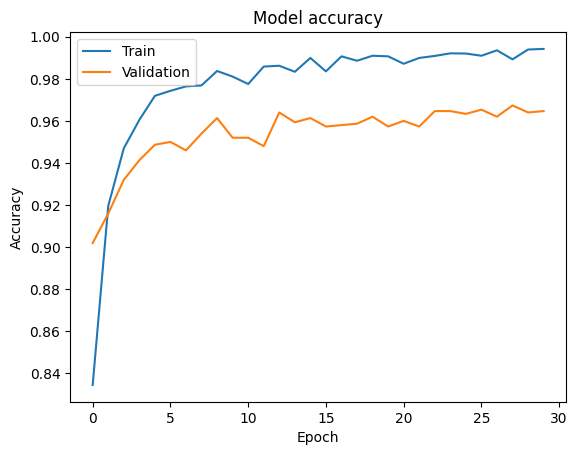

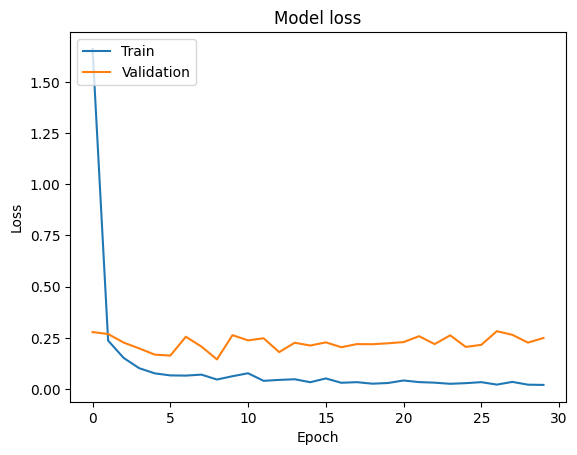

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
import tensorflow as tf
import numpy as np

def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)
for i in range(min(len(images_batch), 9)):
    predicted_class, confidence = predict(model, images_batch[i], class_names)
    actual_class = class_names[np.argmax(labels_batch[i])]

    print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%


In [16]:
model.save("Model_vgg16.h5")